In [1]:
import sys
sys.path.append('../src')
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.special import erfinv
from sklearn.decomposition import DictionaryLearning
from sparse_coding_model import SparseCoding
from utils import *
from train_funcs import load_models, generate_HVC
rng = np.random.default_rng()

In [2]:
def learn_action_basis(dir_adult_songs, n_action_basis):
    # load spectrograms of the syllables for training
    adult = np.load(dir_adult_songs)['spec_syl']
    n_samples, n_syl, n_freq_bins, n_time_bins = adult.shape
    adult = np.concatenate(adult, axis=0)
    adult = adult.reshape(adult.shape[0], -1)
    
    dl = DictionaryLearning(n_components=n_action_basis, 
                            transform_algorithm='lasso_lars')
    a = dl.fit_transform(adult)

    return dl, a, n_time_bins
    
dl, a, n_time_bins = learn_action_basis('../adult_songs/data.npz', n_action_basis=10)

In [3]:
class Environment:
    VOCAL_ERR_NET_MAP = {'FF': 0, 'EI-HVC2E': 1, 'EI-E2E': 2, 'EI-E2I2E': 3}
    
    def __init__(self, action_basis, n_time_bins, dir_sensory_net, 
                 dir_vocal_error_net, vocal_error_net_type):
        # action basis
        self.action_basis = action_basis
        self.action_dim = action_basis.shape[0]
        
        # sensory net
        sensory_basis = torch.load(dir_sensory_net)
        assert sensory_basis.shape[0] % n_time_bins == 0
        self.n_sensory_basis = sensory_basis.shape[1]
        self.n_time_bins = n_time_bins
        self.n_freq_bins = int(sensory_basis.shape[0] // n_time_bins)
        self.sensory = SparseCoding(n_basis=self.n_sensory_basis, 
                                    n_freq_bins=self.n_freq_bins, 
                                    n_time_bins=self.n_time_bins)
        self.sensory.basis = sensory_basis

        # vocal error net
        ret = load_models(dir_vocal_error_net, 'neighbor', 'EIIE', 'mature_hvc', 0)
        self.ve_net = ret[Environment.VOCAL_ERR_NET_MAP[vocal_error_net_type]]
        self.sensory_mapping = ret[-1]
        self.state_dim = self.ve_net.W.shape[1]
        self.init_ve_net()

    def init_ve_net(self):
        self.hE0 = rng.normal(loc=-10, scale=0.5, size=self.ve_net.NE)
        if hasattr(self.ve_net, 'NI'):
            self.hI0 = rng.normal(loc=-1, scale=0.5, size=self.ve_net.NI)
        else:
            self.hI0 = -1
    
    def perform(self, action):
        recon = (action.numpy() @ self.action_basis)
        recon = recon.reshape(self.n_freq_bins, self.n_time_bins)
        emb = self.sensory(torch.tensor(recon, dtype=torch.float32), n_iter_coef=200)
        emb = np.squeeze(emb.numpy()) @ self.sensory_mapping
        return recon, emb

    def reward(self, rH, aud, h0s=None):
        aud = np.broadcast_to(aud, (rH.shape[0], aud.shape[0]))
        if h0s == None:
            hE0, hI0 = self.hE0, self.hI0
        else:
            hE0, hI0 = h0s
        rE, rI, _, hE, hI = self.ve_net.sim(hE0, hI0=hI0, rH=rH, aud=aud, 
                                            save_W_ts=[], T=len(aud), dt=1, 
                                            noise_strength=0, no_progress_bar=True)
        self.hE0, self.hI0 = hE, hI
        return -rE.mean(axis=0)
    
    def burn_vocal_error_model(self, T, h0s=None):
        if h0s == None:
            hE0, hI0 = self.hE0, self.hI0
        else:
            hE0, hI0 = h0s
        rH = np.zeros((T, self.ve_net.NH))
        aud = np.zeros((T, self.ve_net.NE))
        rE, rI, _, hE, hI = self.ve_net.sim(hE0, hI0=hI0, rH=rH, aud=aud, 
                                            save_W_ts=[], T=len(aud), dt=1, 
                                            noise_strength=0, no_progress_bar=True)
        self.hE0, self.hI0 = hE, hI

In [4]:
class Actor(nn.Module):
    def __init__(self, N_in, N_out, action_std):
        super(Actor, self).__init__()
        self.mean = nn.Linear(N_in, N_out)
        self.std = nn.Linear(N_in, N_out)

    def forward(self, state):
        mean = self.mean(state)
        std = torch.exp(self.std(state))
        with torch.no_grad():
            action = torch.randn_like(mean) * std + mean
        return action, mean, std

class Critic(nn.Module):
    def __init__(self, N_in):
        super(Critic, self).__init__()
        self.net = nn.Linear(N_in, 1)

    def forward(self, state):
        return self.net(state)

In [5]:
env = Environment(dl.components_, n_time_bins, 
                  '../realistic_auditory_processing/net_params.pkl', 
                  '../results/', 'EI-E2I2E')

In [6]:
actor = Actor(env.state_dim, env.action_dim, 1)
critic = Critic(env.state_dim)

optimizer_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
optimizer_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)

In [7]:
PEAK_RATE, KERNEL_WIDTH = 150, 20
fname = '../realistic_auditory_processing/learned_song_responses.npz'
T_song = np.load(fname)['ctrl'].shape[2] # (n_songs, N, T)
T_pre = 50 # Silence after song
T_post = 50 # Silence after song
T_rend = T_pre + T_song + T_post
burst_ts = np.linspace(T_pre, T_pre+T_song, num=env.state_dim, endpoint=False)[:,None]
_ = rng.standard_normal((env.state_dim,1)) # Little fluctuation
rH = generate_HVC(T_rend, burst_ts, PEAK_RATE+_*0, KERNEL_WIDTH+_*0)

In [8]:
adult = np.load('../adult_songs/data.npz')
correct_responses = []
env.init_ve_net()
env.burn_vocal_error_model(500)
for k in range(adult['spec_syl'].shape[1]):
    t_on, t_off = T_pre + int(adult['syl_on'][0,k]), T_pre + int(adult['syl_off'][0,k])
    syl = adult['spec_syl'][0,k]
    emb = env.sensory(torch.tensor(syl, dtype=torch.float32), n_iter_coef=200)
    emb = np.squeeze(emb.numpy()) @ env.sensory_mapping
    r = env.reward(rH[t_on:t_off], emb)
    correct_responses.append(r)

    if k + 1 < adult['spec_syl'].shape[1]:
        t_on_next = T_pre + int(adult['syl_on'][0,k+1])
    else:
        t_on_next = T_rend
    r = env.reward(rH[t_off:t_on_next], np.zeros_like(emb))
    correct_responses.append(r)
    
incorrect_responses = []
env.init_ve_net()
env.burn_vocal_error_model(500)
for k in range(adult['spec_syl'].shape[1]):
    if k != 2:
        syl = adult['spec_syl'][0,k]
        emb = env.sensory(torch.tensor(syl, dtype=torch.float32), n_iter_coef=200)
        emb = np.squeeze(emb.numpy()) @ env.sensory_mapping
    else:
        syl, emb = env.perform(torch.randn(size=(10,)))
    t_on, t_off = T_pre + int(adult['syl_on'][0,k]), T_pre + int(adult['syl_off'][0,k])
    r = env.reward(rH[t_on:t_off], emb)
    incorrect_responses.append(r)

    if k + 1 < adult['spec_syl'].shape[1]:
        t_on_next = T_pre + int(adult['syl_on'][0,k+1])
    else:
        t_on_next = T_rend
    r = env.reward(rH[t_off:t_on_next], np.zeros_like(emb))
    incorrect_responses.append(r)

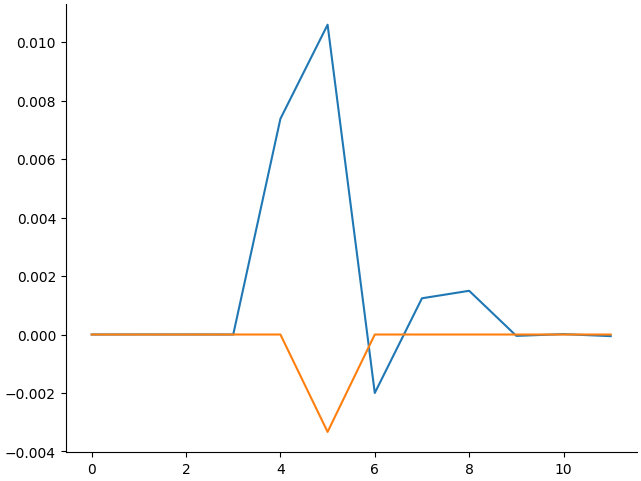

In [9]:
# fig, ax = plt.subplots(2)
# ax[0].imshow(-np.stack(correct_responses, 1), vmin=0, vmax=15)
# ax[1].imshow(-np.stack(incorrect_responses, 1), vmin=0, vmax=15)
diff = np.stack(correct_responses, 1)-np.stack(incorrect_responses, 1)
plt.plot(np.mean(diff, axis=0))
diff = np.mean(np.stack(correct_responses, 1) < -5, axis=0) \
     - np.mean(np.stack(incorrect_responses, 1) < -5, axis=0)
plt.plot(diff)

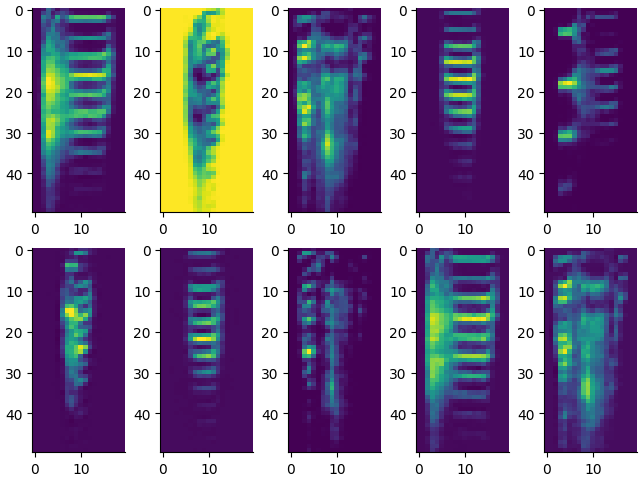

In [10]:
fig, ax = plt.subplots(2, 5)
ax = ax.flatten()
for i, c in enumerate(dl.components_):
    ax[i].imshow(c.reshape(50, 20))

State at step $i$: $$s_i = \tau^{-1} \sum_{t'=0}^{\tau}\mathbf r^H(i\cdot\tau+t')$$

Action: 10-dimensional coefficients for 10 basis of spectrograms $$a_i \sim N(\pi(s_i), \sigma I)$$

Reward: $$v_i = -m\left(\tau^{-1} \sum_{s=0}^{\tau} \mathbf r^E(\mathbf r^H(i\cdot\tau+s), a_i)\right)$$

In [13]:
def calc_actor_loss(action, action_mean, action_std):
    log1 = (action - action_mean)**2 / action_std**2
    log2 = -torch.log(action_std)/2
    return (log1 + log2).sum() * td_err.detach()

In [ ]:
gamma = 0.9
interval = 25
states = [torch.tensor(rH[t:t+interval*2].mean(axis=0), dtype=torch.float32) 
          for t in range(0, T_song, interval)]
states = [(s - s.mean()) / s.std() for s in states]

actor_losses, critic_losses, rewards = [], [], []
actions = []
songs = []

for epoch in tqdm(range(101)):
    env.init_ve_net()
    env.burn_vocal_error_model(500)

    actions.append([])
    if epoch % 10 == 0:
        songs.append([])
    for t, state in enumerate(states):
        optimizer_critic.zero_grad()
        optimizer_actor.zero_grad()
        
        action, action_mean, action_std = actor(state)
        song, song_emb = env.perform(action)

        actions[-1].append(action)
        if epoch % 10 == 0:
            songs[-1].append(song.copy())
        
        r = env.reward(rH[t*interval:(t+2)*interval], song_emb)
        # r = np.mean(r < -3) * 100
        r = r.mean()
        
        val = critic(state)
        # with torch.no_grad():
        if t + 1 < len(states):
            next_state = states[t+1]
            with torch.no_grad():
                next_val = critic(next_state)
        else:
            next_val = 0
        td_target = r + gamma * next_val
        td_err = td_target - val

        # losses
        critic_loss = (td_target - val)**2
        actor_loss = calc_actor_loss(action, action_mean, action_std)

        # log
        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        rewards.append(r)
        
        # updates
        critic_loss.backward()
        optimizer_critic.step()
        actor_loss.backward()
        optimizer_actor.step()

 75%|███████████████████████████████▌          | 76/101 [01:56<00:37,  1.50s/it]

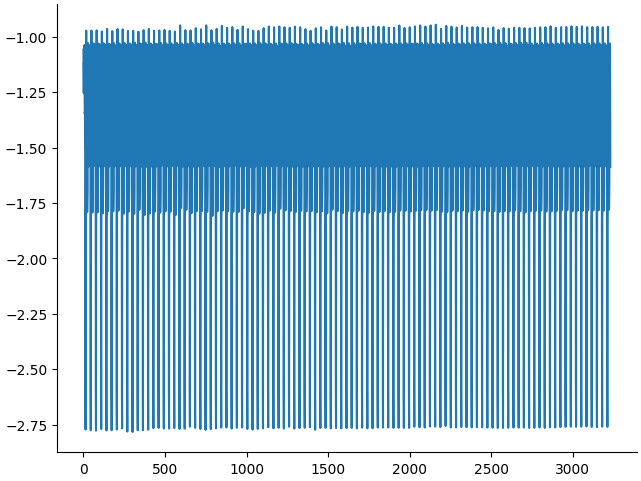

In [21]:
plt.plot(rewards)

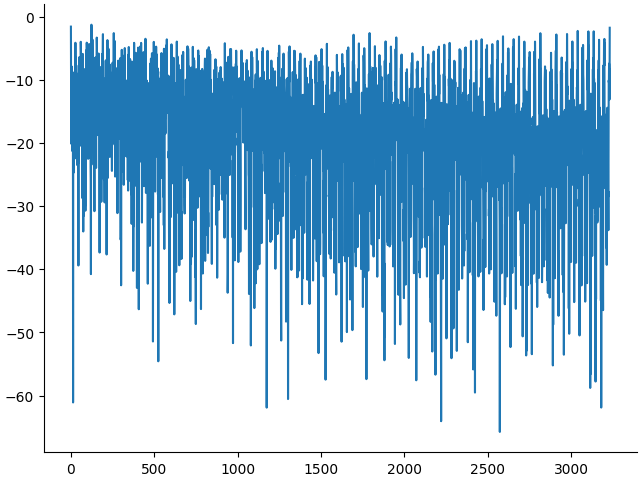

In [22]:
plt.plot(actor_losses)

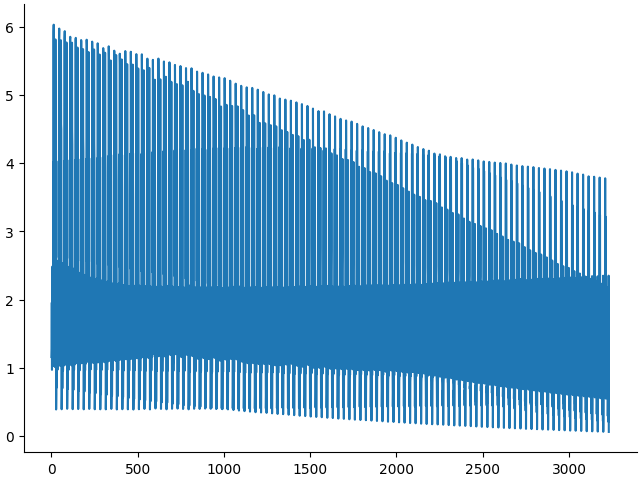

In [23]:
plt.plot(critic_losses)

In [24]:
actions = np.stack([np.stack(_, 0) for _ in actions], 0)

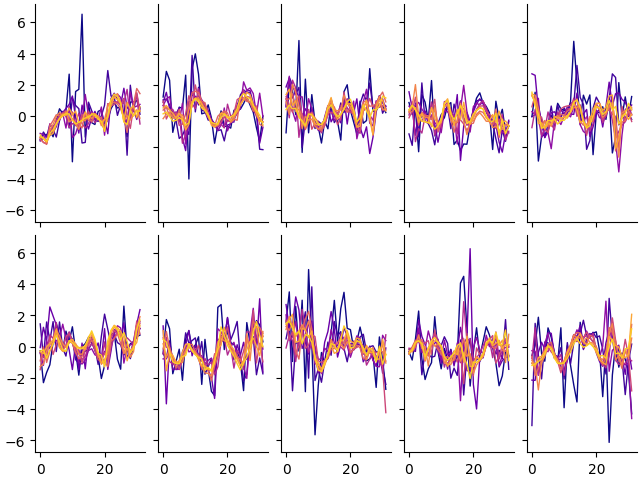

In [25]:
fig, ax = plt.subplots(2, 5, sharex='all', sharey='all')
ax = ax.flatten()
cmap = plt.get_cmap('plasma')
for i in range(10):
    for j in range(0, 100, 10):
        ax[i].plot(actions[j,:,i], color=cmap(j/100), lw=1)

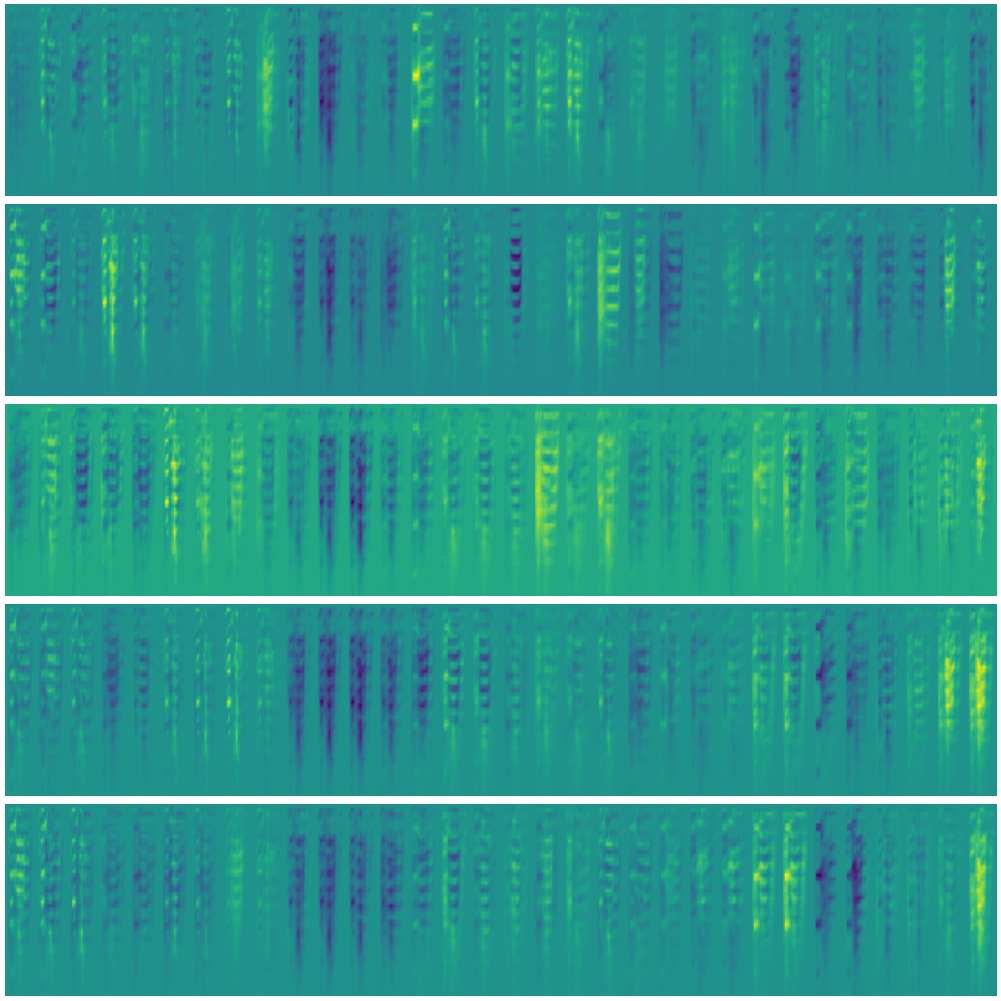

In [26]:
fig, ax = plt.subplots(5, figsize=(10, 10))
for i in range(0, 10, 2):
    ax[i//2].imshow(np.concatenate(songs[i][:len(states)], axis=1))
    ax[i//2].set_axis_off()